## Load Tools

In [1]:
%matplotlib inline

import numpy as np
import pickle
import cv2
import glob
import time
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Setup output path
out_path = "./output_images/"
input_path = "./test_images/"

# Read in test images
test_images = os.listdir(input_path)
test_images.pop(0)
print(test_images)

['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


## Load Training Images

In [2]:
car_images = glob.glob('./vehicles/**/*.png')
noncar_images = glob.glob('./non-vehicles/**/*.png')
print("car images: ", len(car_images))
print("noncar images: ", len(noncar_images))

car images:  8792
noncar images:  8968


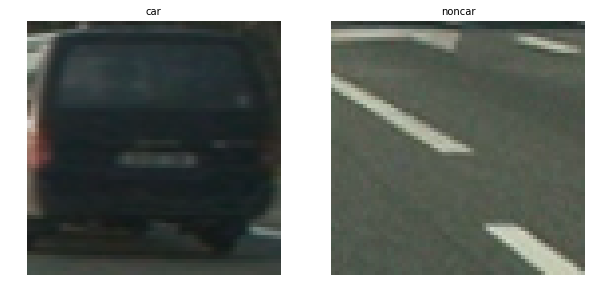

In [3]:
# Display one sample for each dataset
fig, axs = plt.subplots(1,2, figsize=(10, 10))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
img1 = cv2.imread(car_images[np.random.randint(0,len(car_images))])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2 = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
axs[0].axis('off')
axs[0].set_title('car', fontsize=10)
axs[0].imshow(img1)
axs[1].axis('off')
axs[1].set_title('noncar', fontsize=10)
axs[1].imshow(img2)


## Feature Extraction

In [4]:
# These functions are modified from lecture material

# Method to extract HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

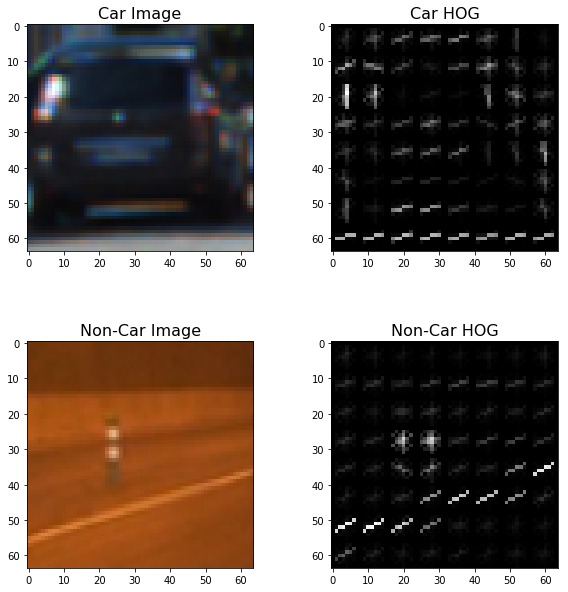

In [5]:
# Show example of car and noncar HOG features
car_img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
_, car_dst = get_hog_features(car_img[:,:,0], 11, 8, 2, vis=True, feature_vec=True)
noncar_img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
_, noncar_dst = get_hog_features(noncar_img[:,:,0], 11, 8, 2, vis=True, feature_vec=True)

car_img = cv2.cvtColor(car_img,cv2.COLOR_BGR2RGB)
noncar_img = cv2.cvtColor(noncar_img,cv2.COLOR_BGR2RGB)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

## Extract Features from A List of Image Files

In [6]:
# This function is modified from lecture material
# Define a function to extract HOG features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #print(hog_features.shape)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features, spatial_features, hist_features)))
    # Return list of feature vectors
    return features

## Prepare Training Data

In [7]:
# Parameters for feature extraction
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16)
hist_bins = 32
hist_range = (0,256)

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.3, random_state=rand_state)

print('Orientations = ',orient,', Pixels per cell = ',pix_per_cell,
      ', Cells per block = ', cell_per_block)
print('Training feature length:', len(X_train[0]))

77.93 Seconds to extract HOG features...
Orientations =  11 , Pixels per cell =  8 , Cells per block =  2
Training feature length: 7332


## Train Linear SVM Classifier

In [8]:
# Use a linear SVC 
svc = LinearSVC()

# Generate grid for GridSearchCV
#parameters = {'C':[1, 10]}
#clf = GridSearchCV(svc, parameters)
# Automatically train model with optimal parameters
#clf.fit(X_train, y_train)
#print(clf.best_params_)

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 16
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

16.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  1.  1.  0.]
For these 16 labels:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  0.]
0.00246 Seconds to predict 16 labels with SVC


## Using Classifier to detect cars in an image

In [12]:
# Define a function to convert color
# Function adapted from lecture material
def convert_color(img, conv='HSV'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    

# Define a single function that can extract features using hog sub-sampling and make predictions
# Function adapted from lecture material
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    #Create a list to hold rectangles to hold detected cars
    rectangles = []
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img, colorspace)
    print(colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    print('Orientations = ',orient,', Pixels per cell = ',pix_per_cell,
      ', Cells per block = ', cell_per_block)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            plt.imshow(subimg)
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Combine features
            raw_features = np.concatenate((hog_features, spatial_features, hist_features))
            #print(hog_features.shape)

            # Scale features and make a prediction
            #new_scaler = StandardScaler().fit(raw_features)
            test_features = X_scaler.transform(raw_features)       
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

## Detect Cars in Test Images

HSV
Orientations =  11 , Pixels per cell =  8 , Cells per block =  2
23 rectangles found in image: test1.jpg
HSV
Orientations =  11 , Pixels per cell =  8 , Cells per block =  2
5 rectangles found in image: test2.jpg
HSV
Orientations =  11 , Pixels per cell =  8 , Cells per block =  2
4 rectangles found in image: test3.jpg
HSV
Orientations =  11 , Pixels per cell =  8 , Cells per block =  2
18 rectangles found in image: test4.jpg
HSV
Orientations =  11 , Pixels per cell =  8 , Cells per block =  2
97 rectangles found in image: test5.jpg
HSV
Orientations =  11 , Pixels per cell =  8 , Cells per block =  2
45 rectangles found in image: test6.jpg


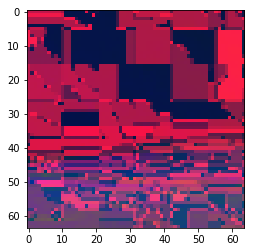

In [13]:
ystart = 400
ystop = 656
scale = 1.5

# Method to draw bounding box outside each car
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    # Make a copy of the image
    img_copy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(img_copy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return img_copy

for img_path in test_images:
    
    test_img = mpimg.imread(input_path + img_path)
    bbox = find_cars(test_img, ystart, ystop, scale, 
                           svc, X_scaler, orient, pix_per_cell, cell_per_block,
                           spatial_size, hist_bins)
    draw_img = draw_boxes(test_img, bbox)
    
    # Save binary image
    cv2.imwrite(os.path.join(out_path, "rect_"+ img_path), draw_img)
    print(len(bbox), 'rectangles found in image: '+ img_path)